# Compute the MAP example with the `QuantifAI` model using simulated MeerKAT ungridded visibilities

In this notebook we:
- set hyperparameters,
- prepare the synthetic observations,
- define the model, likelihood and prior,
- estimate the MAP reconstruction through a convex optimisation algorithm,
- plot the MAP estimation result and the error.



In [1]:
import os
import numpy as np
import time as time

# Import torch and select GPU
import torch

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(torch.cuda.is_available())
    print(torch.cuda.device_count())
    print(torch.cuda.current_device())
    print(torch.cuda.get_device_name(torch.cuda.current_device()))

# Plot functions
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Radio and convex reg functions
import quantifai as qai
from quantifai.utils import to_numpy, to_tensor
from convex_reg import utils as utils_cvx_reg

True
1
0
NVIDIA A100-PCIE-40GB


## Set hyperparameters 

In [3]:
# Parameters

# Optimisation options for the MAP estimation
options = {"tol": 1e-5, "iter": 15000, "update_iter": 100, "record_iters": False}

# Save param
repo_dir = "./.."

# Test image name from ['M31', 'W28', 'CYN', '3c288']
img_name = "M31"
# Input noise level
input_snr = 30.0

# Define my torch types (CRR requires torch.float32)
myType = torch.float32
myComplexType = torch.complex64

# CRR load parameters
sigma_training = 5
t_model = 5
CRR_dir_name = "./../trained_models/"
# CRR parameters
lmbd = 1e4  # lambda parameter
mu = 20

## Load visibilities

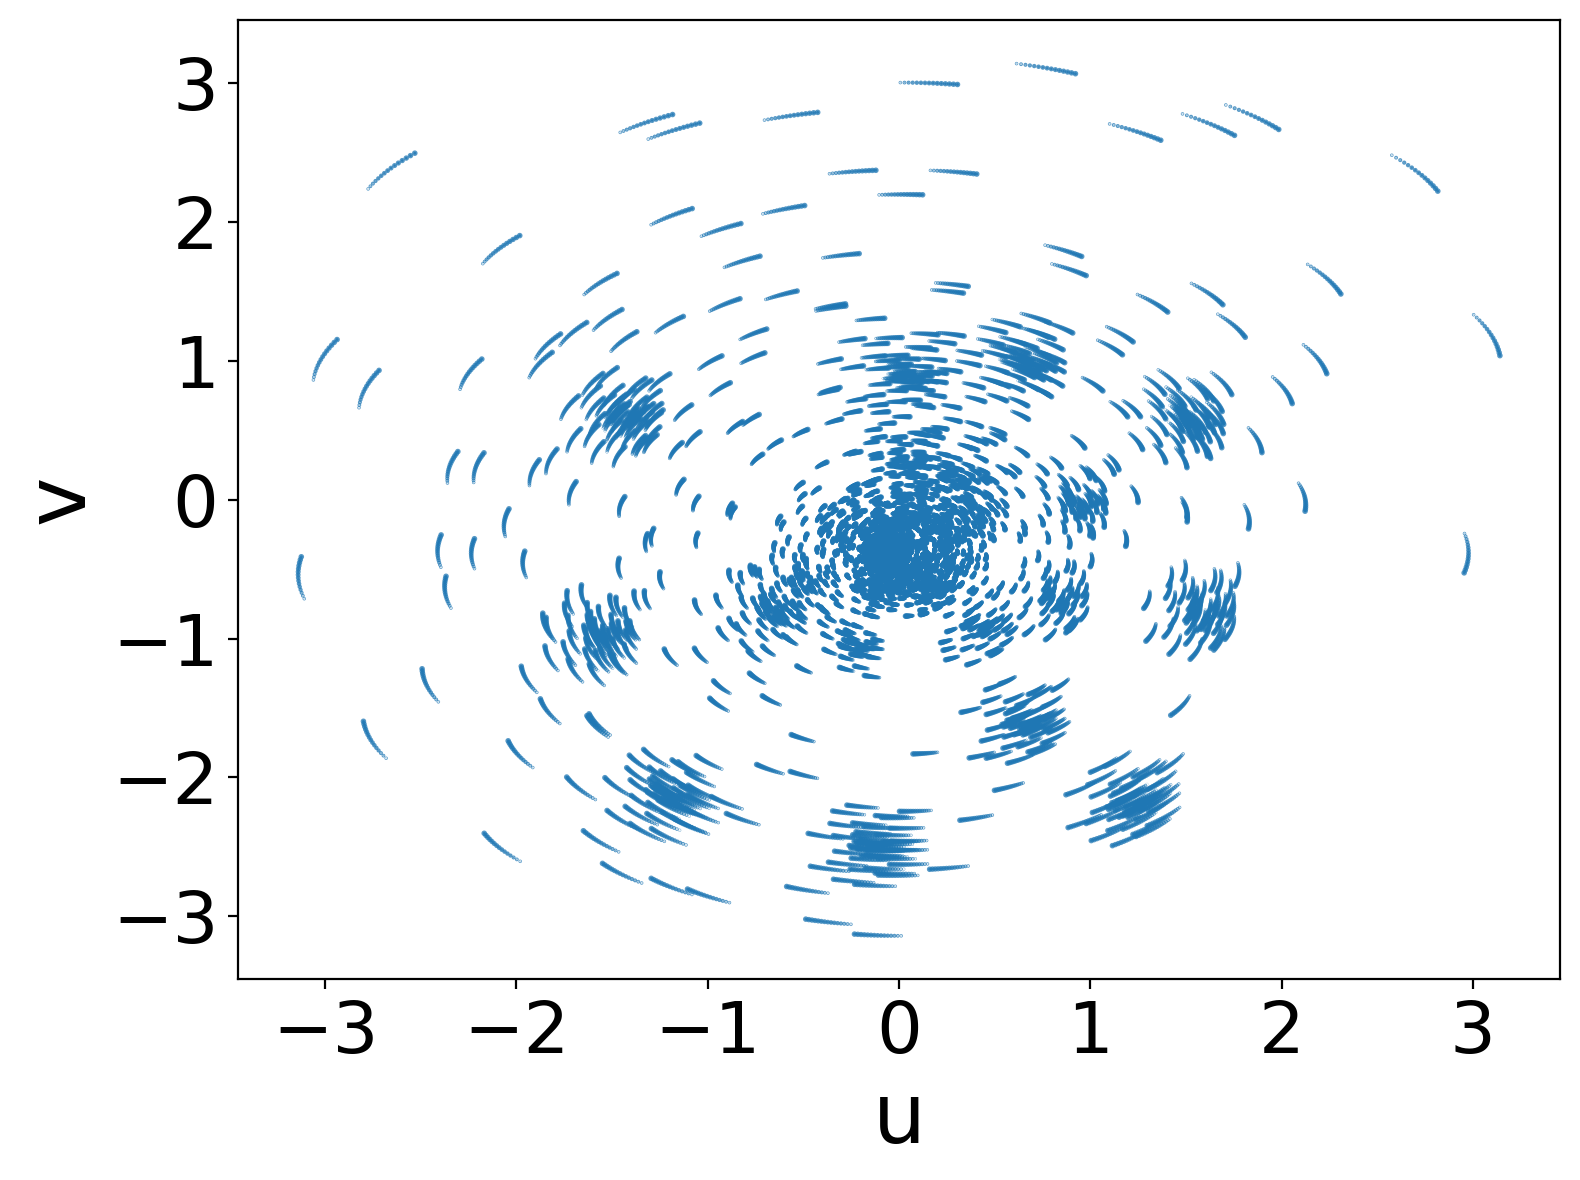

In [6]:
uv_path = repo_dir + "/data/meerkat_ungridded_vis/meerkat_simulation_1h_uv_only.npy"
uv_data = np.load(uv_path, allow_pickle=True)[()]
uv = np.concatenate((uv_data['uu'].reshape(-1,1), uv_data['vv'].reshape(-1,1)), axis=1)


plt.figure(figsize=(8,6), dpi=200)
s = (np.arange(len(uv[:,0])) + 1) / (len(uv[:,0]))
ax = plt.gca()
plt.scatter(uv[:,0], uv[:,1], s=s, alpha=0.75)

plt.xticks(fontsize=26)
plt.yticks(fontsize=26)

plt.xlabel(r"u", fontsize=30)
plt.ylabel(r"v", fontsize=30)
plt.tight_layout()
# plt.savefig(save_dir + "meerkat_" + vis_time + "_uv_coverage.jpg")
plt.show()

# Prepare observations 

### Define NUFFT-based forward operator phi 

In [7]:
# Load image and mask
img, _ = qai.helpers.load_imgs(img_name, repo_dir)

# Aliases
x = img
ground_truth = img


torch_img = torch.tensor(np.copy(img), dtype=myType, device=device).reshape(
    (1,) + img.shape
)


torch_img = torch.tensor(np.copy(img), dtype=myType, device=device).reshape(
    (1,1) + img.shape
)
torch_uv = torch.tensor(uv.T, device=device, dtype=myType)

phi = qai.operators.KbNuFFT2d_torch(
    uv=torch_uv,
    im_shape=img.shape,
    device=device,
    interp_points=6,
    k_oversampling=2,
    myType=myType,
    myComplexType=myComplexType
)


INSTRUME                                                                         [astropy.io.fits.card]


### Generate observations

In [8]:
y = phi.dir_op(torch_img).detach().cpu().squeeze().numpy()

# Define noise level
eff_sigma = qai.helpers.compute_complex_sigma_noise(y, input_snr)
sigma = eff_sigma * np.sqrt(2)

# Generate noise
rng = np.random.default_rng(seed=0)
n_re = rng.normal(0, eff_sigma, y[y != 0].shape)
n_im = rng.normal(0, eff_sigma, y[y != 0].shape)
# Add noise
y[y != 0] += n_re + 1.0j * n_im

# Observation
torch_y = torch.tensor(np.copy(y), device=device, dtype=myComplexType)[None, None, :]

# Generate first guess
x_init = torch.abs(phi.adj_op(torch_y))


# Define likelihood and prior

In [9]:
# Define the likelihood
likelihood = qai.operators.L2Norm_torch(
    sigma=sigma,
    data=torch_y,
    Phi=phi,
    im_shape=x_init.shape
)
# Lipschitz constant computed automatically by g, stored in g.beta

# Define real prox
prox_op = qai.operators.RealProx_torch()

In [10]:
# Load CRR model
torch.set_grad_enabled(False)
torch.set_num_threads(4)

exp_name = f"Sigma_{sigma_training}_t_{t_model}/"
if device.type == "cpu":
    CRR_model = utils_cvx_reg.load_model(
        CRR_dir_name + exp_name, "cpu", device_type="cpu"
    )
elif device.type == "cuda":
    CRR_model = utils_cvx_reg.load_model(
        CRR_dir_name + exp_name, "cuda", device_type="gpu"
    )


print(f"Numbers of parameters before prunning: {CRR_model.num_params}")
CRR_model.prune()
print(f"Numbers of parameters after prunning: {CRR_model.num_params}")

--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 - linear_spline activation functions
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
Numbers of parameters before prunning: 13610
---------------------
 PRUNNING 
 Found 22 filters with non-vanishing potential functions
---------------------
Numbers of parameters after prunning: 4183


In [11]:
# [not required] intialize the eigen vector of dimension (size, size) associated to the largest eigen value
CRR_model.initializeEigen(size=100)
# compute bound via a power iteration which couples the activations and the convolutions
L_CRR = CRR_model.precise_lipschitz_bound(n_iter=100)
# the bound is stored in the model
# L_CRR = model.L.data.item()
print(f"Lipschitz bound {L_CRR:.3f}")

Lipschitz bound 0.781


# Run optimisation algorithm anc compute the MAP reconstruction

In [12]:
# Compute stepsize
alpha = 0.98 / (likelihood.beta + mu * lmbd * L_CRR)

x_hat = qai.optim.FISTA_CRR_torch(
    x_init=x_init,
    options=options,
    likelihood=likelihood,
    prox_op=prox_op,
    CRR_model=CRR_model,
    alpha=alpha,
    lmbd=lmbd,
    mu=mu,
)

[GD] 0 out of 15000 iterations, tol = 0.068160
[GD] 100 out of 15000 iterations, tol = 0.002104
[GD] 200 out of 15000 iterations, tol = 0.000411
[GD] 300 out of 15000 iterations, tol = 0.000203
[GD] 400 out of 15000 iterations, tol = 0.000106
[GD] 500 out of 15000 iterations, tol = 0.000073
[GD] 600 out of 15000 iterations, tol = 0.000044
[GD] 700 out of 15000 iterations, tol = 0.000036
[GD] 800 out of 15000 iterations, tol = 0.000028
[GD] 900 out of 15000 iterations, tol = 0.000023
[GD] 1000 out of 15000 iterations, tol = 0.000019
[GD] 1100 out of 15000 iterations, tol = 0.000016
[GD] 1200 out of 15000 iterations, tol = 0.000014
[GD] converged in 1259 iterations


# Plot MAP reconstruction

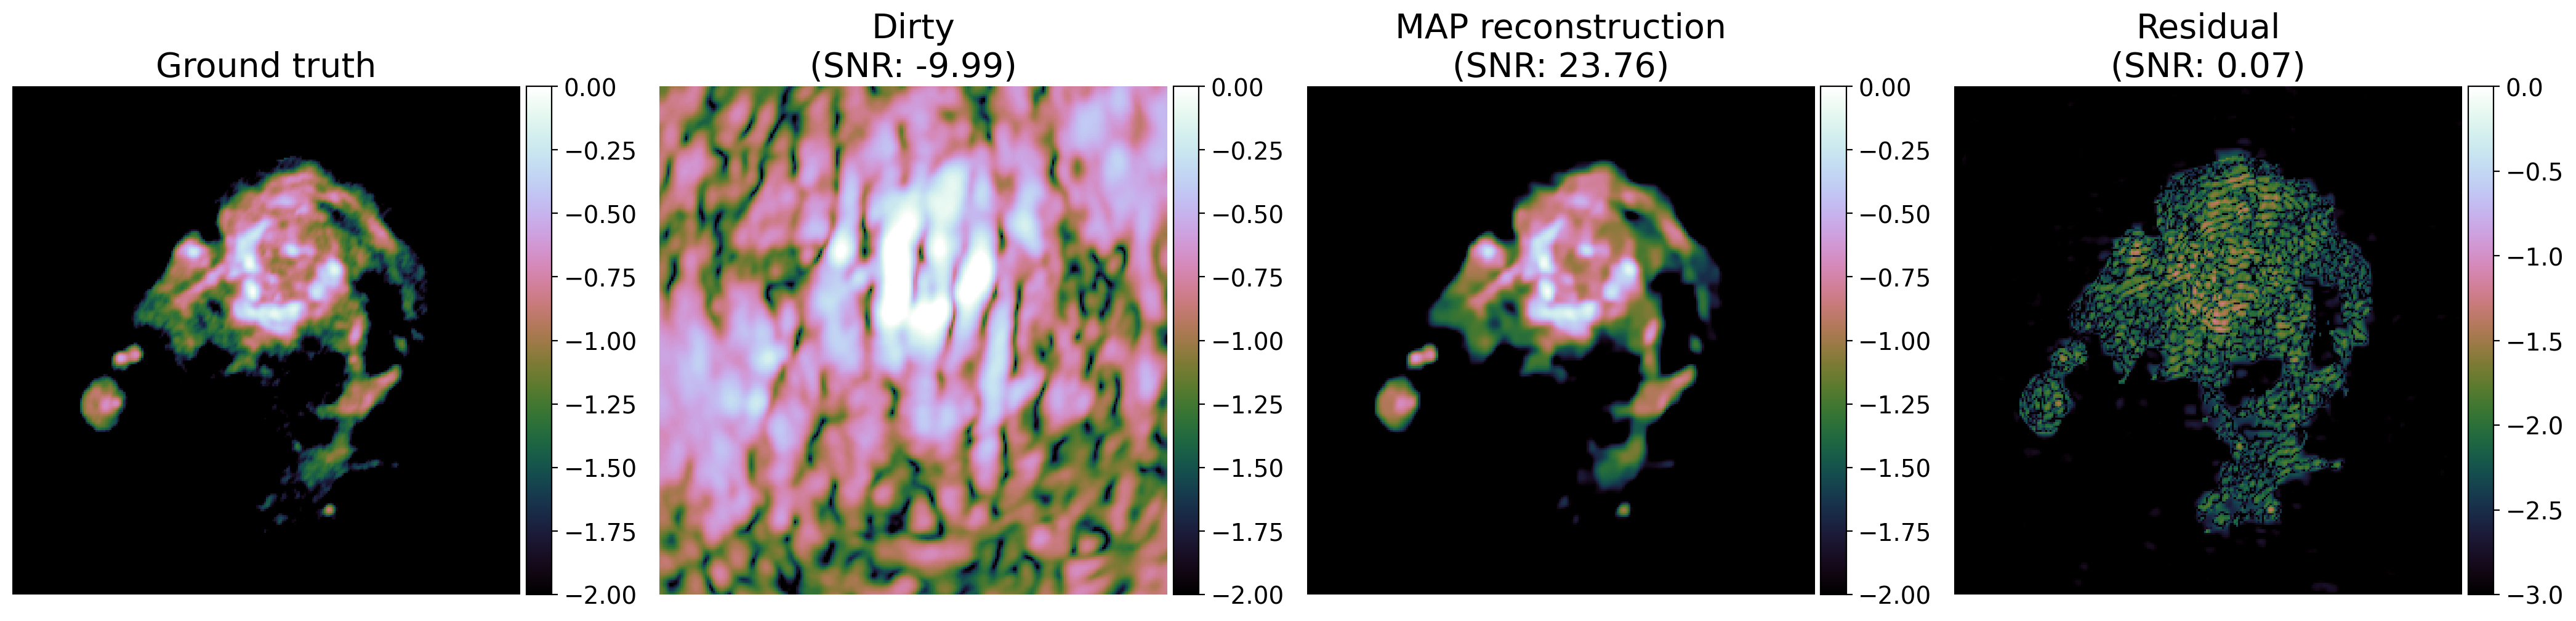

In [13]:
# Convert to numpy
np_x_init = to_numpy(x_init)
x_map = x_hat.clone()
x_gt = np.copy(x)
np_x_gt = np.copy(x)
np_x_map = to_numpy(x_map)


# Need to replace zero values with veery small numbers for the log plots
np_x_gt[np_x_gt == 0] = np.random.rand(np.sum(np_x_gt == 0)) * 1e-7

images = [np_x_gt, np_x_init, np_x_map, np_x_gt - np.abs(np_x_map)]
labels = ["Ground truth", "Dirty", "MAP reconstruction", "Residual"]
vmin_log = [-2.0, -2.0, -2.0, -3.0]

cmap = "cubehelix"

fig, axs = plt.subplots(1, 4, figsize=(26, 8), dpi=200)
for i in range(4):
    im = axs[i].imshow(np.log10(np.abs(images[i])), cmap=cmap, vmax=0, vmin=vmin_log[i])
    divider = make_axes_locatable(axs[i])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(im, cax=cax, orientation="vertical")
    cbar.ax.tick_params(labelsize=14)
    if i > 0:
        stats_str = "\n(SNR: {})".format(
            round(qai.utils.eval_snr(x, images[i]), 2),
        )
        labels[i] += stats_str
    axs[i].set_title(labels[i], fontsize=20)
    axs[i].axis("off")
plt.show()